# Step 3 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between railway/underground stations (or other points of interest created in 02_prepare_pois). This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-18  
Last modified: 2021-01-23

## Preliminaries

### Parameters

In [1]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.

Setup finished.

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 4c5cd0bc50c1c154868417f99214b4182b4fb9b5

pandas    : 2.2.3
pyproj    : 3.7.0
tqdm      : 4.66.5
geopandas : 0.14.4
osmnx     : 1.9.4
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
watermark : 2.5.0
networkx  : 3.3
rasterio  : 1.3.11
matplotlib: 3.8.4
igraph    : 0.11.6
csv       : 1.0
IPython   : 8.29.0
json      : 2.0.9
numpy     : 1.26.4
fiona     : 1.10.1
owslib    : 0.32.0
shapely   : 2.0.6
geojson   : 3.1.0
osgeo     : 3.9.3
momepy    : 0.8.1
haversine : 2.8.1



### Functions

In [3]:
%run -i functions.py

Loaded functions.



## Routing (shortest paths)

The function and code below currently routes between the edges of neighbourhoods, rather than from a single point to a single point. 

In [4]:
def greedy_triangulation_routing_neighbourhoods(G, pois, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    """Greedy Triangulation (GT) of a graph G's node subset pois,
    then routing to connect the GT (up to a quantile of betweenness
    betweenness_quantile).
    """

    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
        
    if len(pois) < 2: 
        return ([], [])  # We can't do anything with less than 2 POIs

    # GT_abstract is the GT with same nodes but euclidian links to keep track of edge crossings
    pois_indices = set(G.vs.find(id=poi).index for poi in pois)
    G_temp = copy.deepcopy(G)
    for e in G_temp.es:  # Delete all edges
        G_temp.es.delete(e)
        
    poipairs = poipairs_by_distance(G, pois, weighting, True)
    if len(poipairs) == 0: 
        return ([], [])

    print(poipairs)
    
    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G_temp.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else: 
        edgeorder = False
    
    
    GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # Update GT_abstract within each prune_quantile
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        
        # get node pairs we need to route, sorted by distance
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])


#######################
# we want to do between neighbourhoods first, then between other points
# put in here if routenodepair is between two neighbourhoods vs 1 neighbourhood  vs 0 neighbourhoods
#######################


        # do the routing 
        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)

            # Compute the shortest path
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
            exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
            exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs: 
                        continue
                    processed_pairs.add(pair_id)
                    ea_vertex_index = G.vs.find(id=ea).index
                    eb_vertex_index = G.vs.find(id=eb).index
                    sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                    if sp and len(sp) < shortest_path_length:
                        shortest_path_length, best_path = len(sp), sp

            # Accumulate nodes for final GT from best_path
            if best_path:
                all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                GT_indices.update(best_path)  # Add nodes to GT_indices

                # Plotting of current GT for each best_path found
                GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                GT_gjson = ig_to_geojson(GT)
                GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
                
                if GT_geometries:
                    GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

                    if debug:
                        # Plot the GT with neighborhood points and exit points
                        fig, ax = plt.subplots(figsize=(10, 10))
                        GT_gdf.plot(ax=ax, color="blue", linewidth=1, label="GT Edges")
                        neighbourhood_gdf = gpd.GeoDataFrame(
                            geometry=[all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'geometry'].values[0], 
                                    all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'geometry'].values[0]], 
                            crs="EPSG:4326"
                        )
                        neighbourhood_gdf.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Points")
                        exit_points_gdf = gpd.GeoDataFrame(
                            geometry=list(exit_points.loc[exit_points['neighbourhood_id'].isin([neighbourhood_a, neighbourhood_b]), 'geometry']),
                            crs="EPSG:4326"
                        )
                        exit_points_gdf.plot(ax=ax, color="red", marker="x", markersize=30, label="Exit Points")

                        plt.legend()
                        plt.xlabel("Longitude")
                        plt.ylabel("Latitude")
                        plt.title(f"GT with Neighbourhood and Exit Points for POI Pair {poipair}")
                        plt.show()
        
        # Plot cumulative GTs up to the current prune_quantile
        GT = G.induced_subgraph(GT_indices)  # Cumulative GT for current prune_quantile
        GTs.append(GT)

        if debug:
            # Plot GTs after each prune_quantile loop
            fig, ax = plt.subplots(figsize=(10, 10))
            GT_gjson = ig_to_geojson(GT)
            GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
            GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")
            
            GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label="GT Edges")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
            exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="Exit Points")
            
            plt.legend()
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.title("GTs After Adding GT for POI Pair Loop")
            plt.show()

    if debug:
        # Final cumulative plot with all GTs, all centroids, and exit points, and G as background
        fig, ax = plt.subplots(figsize=(10, 10))
        G_gjson = ig_to_geojson(G)
        G_geometries = [shape(geometry) for geometry in G_gjson["geometries"]]
        G_gdf = gpd.GeoDataFrame(geometry=G_geometries, crs="EPSG:4326")
        G_gdf.plot(ax=ax, color="lightgray", linewidth=0.5, label="Full Network (G)")

        # Plot each GT with a unique color
        for idx, GT in enumerate(GTs):
            GT_gjson = ig_to_geojson(GT)
            GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
            
            if GT_geometries:
                GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")
                GT_gdf.plot(ax=ax, color=plt.cm.tab10(idx % 10), linewidth=1.5, label=f"GT {idx+1}")

        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("All GTs After Processing with Full Network, Centroids, and Exit Points")
        plt.show()

    return (GTs, GT_abstracts)


In [5]:
## we need to load data again to ensure we take in neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(placeid + ": loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall) # requires osmnx G_carall, not igraph G_carall
        
    
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items(): # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighborhood in the GeoDataFrame to referance throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug == True:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighborhoods processed

    # Snap centroids to the closest nodes in the street network
    nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            nnids.add(n)
        # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y)) # we now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # generate connections
    print(placeid + ": Generating networks")

    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    # G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting) to load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_neighbourhoods(G_carall, nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)


    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Loading location polygon and carall graph
newcastle: loading and moving POIs
1 Cities loaded


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2058: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded_gdf = gdf.explode().reset_index(drop=True)
c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1861: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration

Processing neighbourhoods in: Newcastle Upon Tyne


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1724: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid  # Calculate centroids for each polygon


newcastle: Generating networks


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:521: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  e['maxspeed'].fillna(20, inplace=True)  # Assign default speed of 20 where NaN


[[(776327239, 345643357), 733.215], [(1448449438, 4140896891), 847.9159999999997], [(1515378949, 1515379090), 996.315], [(9994900108, 4140896891), 1442.5319999999995], [(9994900108, 1448449438), 1536.555], [(1907450682, 826166875), 1541.0669999999998], [(4625261952, 776327239), 1638.0200000000002], [(1448449438, 1907450682), 1864.218], [(4625261952, 345643357), 1938.805], [(252100827, 3438054246), 1980.0639999999999], [(9994900108, 1907450682), 2016.189], [(345643357, 4140896891), 2143.6150000000007], [(1907450682, 4140896891), 2182.7170000000015], [(252100827, 252735590), 2228.423], [(331828240, 252735590), 2269.2169999999996], [(9994900108, 826166875), 2337.5249999999983], [(776327239, 4140896891), 2420.6639999999998], [(1448449438, 776327239), 2560.6469999999995], [(331828240, 252100827), 2625.973999999999], [(1448449438, 345643357), 2641.0500000000006], [(1448449438, 826166875), 2735.1749999999993], [(826166875, 4140896891), 2761.3740000000034], [(3438054246, 252735590), 2813.71899

Greedy triangulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
Audio(sound_file, autoplay=True)

: 

Old experimental code below. Saving here in case we changes things up again and need to use some of the old debugging code again.

In [ ]:
break
## nothing below here is needed

C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:462: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  e['maxspeed'].fillna(20, inplace=True)  # Assign default speed of 20 where NaN


<Axes: >

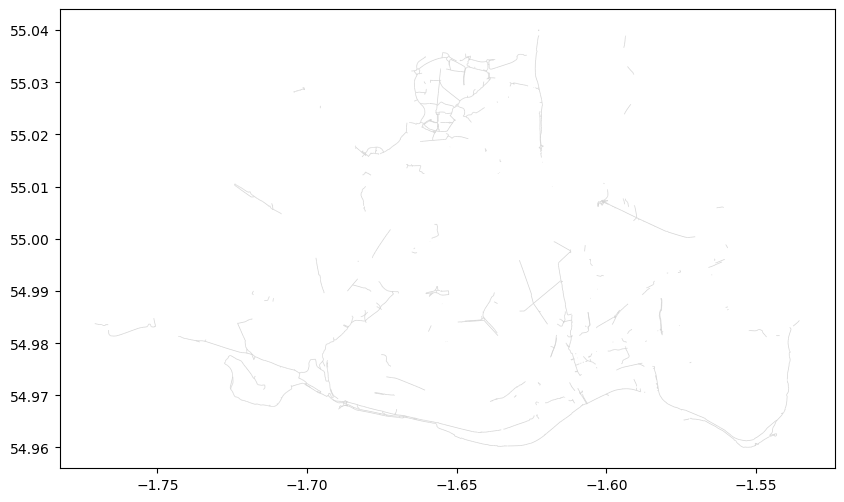

In [15]:
G = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack', weighting=weighting) 
fig, ax = plt.subplots(figsize=(10, 10))
G_gjson = ig_to_geojson(G)
G_geometries = [shape(geometry) for geometry in G_gjson["geometries"]]
G_gdf = gpd.GeoDataFrame(geometry=G_geometries, crs="EPSG:4326")
G_gdf.plot(ax=ax, color="lightgray", linewidth=0.5, label="Full Network (G)")


In [ ]:
######### THIS SECTION LOADS THE DATA WE NEED #########
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": loading and moving POIs")

    # We need the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

   # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and initialize GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  # Adjust the CRS if necessary
    
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    # Process each neighbourhood GeoDataFrame
    for name, gdf in neighbourhoods.items():
        # Check if gdf is empty
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighborhood in the GeoDataFrame
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        
        # Print to confirm ID assignment
        print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids and ensure to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)

        # Append the centroids to all_centroids GeoDataFrame
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)

        # Update unique_id for the next set of neighborhoods
        unique_id += len(gdf)  # Increment by the number of neighborhoods processed

    # Snap centroids to the closest nodes in the street network
    nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            nnids.add(n)
        # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y)
    )


### THIS SECTION OF CODE IS FOR ROUTING BETWEEN EXIT POINTS ###

# Load neighbourhoods and convert graph to GeoDataFrames
neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
exit_points = get_exit_nodes(neighbourhoods, G_carall) # requires osmnx G_carall, not igraph G_carall
print("Got neigbourhoods, exit points, and centroids")

In [ ]:
######### THIS SECTION LOADS THE DATA WE NEED #########
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": loading and moving POIs")

    # We need the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

   # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and initialize GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  # Adjust the CRS if necessary
    
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    # Process each neighbourhood GeoDataFrame
    for name, gdf in neighbourhoods.items():
        # Check if gdf is empty
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighborhood in the GeoDataFrame
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        
        # Print to confirm ID assignment
        print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids and ensure to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)

        # Append the centroids to all_centroids GeoDataFrame
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)

        # Update unique_id for the next set of neighborhoods
        unique_id += len(gdf)  # Increment by the number of neighborhoods processed

    # Snap centroids to the closest nodes in the street network
    nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            nnids.add(n)
        # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y)
    )


### THIS SECTION OF CODE IS FOR ROUTING BETWEEN EXIT POINTS ###

# Load neighbourhoods and convert graph to GeoDataFrames
neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
exit_points = get_exit_nodes(neighbourhoods, G_carall) # requires osmnx G_carall, not igraph G_carall
print("Got neigbourhoods, exit points, and centroids")

# Load networks
G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)

all_shortest_paths = []
GTs = []
GT_abstracts = []
processed_pairs = set()  # To track processed exit point pairs



print("Beginning routing between exit points")
# Get points based on neighbourhood centroids
pois = all_centroids['nearest_node'].tolist()
poipairs = poipairs_by_distance(G_carall, pois, weighting, return_distances=True)

# Track processed exit point pairs to avoid redundant routing
processed_pairs = set()

for prune_quantiles in tqdm(prune_quantiles, desc = "Greedy Triangulation with neighbourhoods", leave = False):
    # Process each POI pair from poipairs
    for (node_a, node_b), distance in tqdm(poipairs):
        print("Processing POI pair:", node_a, node_b)
        # Identify neighborhoods for each POI and retrieve their exit points
        neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == node_a, 'neighbourhood_id'].values[0]
        neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == node_b, 'neighbourhood_id'].values[0]
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
        shortest_path_length, best_path, edges_in_best_path = float('inf'), None, []
        # Compute shortest paths between exit point pairs
        for ea in exit_points_a:
            for eb in exit_points_b:
                pair_id = tuple(sorted((ea, eb)))
                if pair_id in processed_pairs: 
                    continue  # Skip if already processed
                processed_pairs.add(pair_id)
                ea_vertex_index = G_carall.vs.find(id=ea).index
                eb_vertex_index = G_carall.vs.find(id=eb).index
                sp = G_carall.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                # Update if a shorter path is found
                if sp:
                    path_length = len(sp)
                    if path_length < shortest_path_length:
                        shortest_path_length, best_path = path_length, sp
                        edges_in_best_path = [(sp[i], sp[i + 1]) for i in range(len(sp) - 1)]

        # Store the results if a path was found
        if shortest_path_length < float('inf'):
            #print(f"Shortest path between {node_a} and {node_b} is {shortest_path_length}")
            all_shortest_paths.append((node_a, node_b, shortest_path_length, best_path))
            # Create subgraphs for GT 
            GT = G_carall.induced_subgraph([G_carall.vs[idx] for idx in best_path])
            GTs.append(GT)
            print("Stored GT")
        else:
            print(f"No path found between {node_a} and {node_b}")

In [ ]:
## attempt 4
# Load graph and set CRS if not present
G_carall = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
if 'crs' not in G_carall.graph:
    G_carall.graph['crs'] = 'epsg:4326'

# Load neighbourhoods and convert graph to GeoDataFrames
neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
exit_points = get_exit_nodes(neighbourhoods, G_carall)




# edges = ox.graph_to_gdfs(G_carall, nodes=False, edges=True)
# nodes = ox.graph_to_gdfs(G_carall, nodes=True, edges=False)

# # Add unique IDs to each polygon in neighbourhoods and buffer them
# boundary_buffers = {}
# for place_name, gdf in neighbourhoods.items():
#     exploded_gdf = gdf.explode().reset_index(drop=True)
#     exploded_gdf['neighbourhood_id'] = exploded_gdf.index  # Unique ID for each polygon
#     buffer = exploded_gdf.boundary.to_crs(epsg=3857).buffer(10).to_crs(exploded_gdf.crs)  # 10-meter buffer
#     boundary_buffers[place_name] = (buffer, exploded_gdf)

# # Combine all buffers into a single GeoDataFrame and set the geometry
# buffer_geometries = [boundary_buffers[place][0] for place in boundary_buffers]
# neighbourhood_geometries = [boundary_buffers[place][1]['neighbourhood_id'] for place in boundary_buffers]

# # Create a GeoDataFrame from the geometries
# boundary_buffers_gdf = gpd.GeoDataFrame(geometry=pd.concat(buffer_geometries, ignore_index=True))
# boundary_buffers_gdf['neighbourhood_id'] = pd.concat(neighbourhood_geometries, ignore_index=True)

# # Ensure CRS is set correctly
# nodes_within_buffer = gpd.sjoin(nodes, boundary_buffers_gdf, how='inner', op='intersects')
# #nodes_within_buffer = nodes[nodes.geometry.apply(lambda point: buffer.contains(point).any())]

# street_buffers = {}
# for place_name, gdf in neighbourhoods.items():
#     street_nodes, street_edges = get_neighbourhood_streets_split(gdf, debug=False)
#     # Buffering edges with correct CRS
#     street_buffer = street_edges.to_crs(epsg=3857).geometry.buffer(100).to_crs(street_edges.crs)
#     street_buffers[place_name] = gpd.GeoDataFrame(geometry=street_buffer, crs=street_edges.crs)


# streets_buffer_gdf = gpd.GeoDataFrame(
#     pd.concat([gdf for gdf in street_buffers.values()]), 
#     crs=next(iter(street_buffers.values())).crs
# )


# # Drop the 'index_right' column to avoid conflict (fix later)
# if 'index_right' in nodes_within_buffer.columns:
#     nodes_within_buffer = nodes_within_buffer.drop(columns=['index_right'])

# nodes_within_buffer = gpd.sjoin(nodes_within_buffer, streets_buffer_gdf, how='inner', op='intersects')






# # Initialize a dictionary to hold GeoDataFrames of nodes within each buffered boundary
# boundary_nodes = {place_name: gpd.GeoDataFrame(columns=nodes.columns) for place_name in buffered_boundaries.keys()}

# # Find nodes within buffered boundaries
# for place_name, (buffer, gdf) in buffered_boundaries.items():
#     intersecting_nodes = []
#     for idx, node in nodes.iterrows():
#         # Check intersection with the buffered boundary
#         if buffer.intersects(node.geometry).any():
#             # Get the unique neighbourhood_id from the corresponding polygon
#             for poly_idx, poly in gdf.iterrows():
#                 if poly.geometry.intersects(node.geometry):  # Check if the node intersects the polygon
#                     node_with_id = node.copy()  # Create a copy of the node
#                     node_with_id['neighbourhood_id'] = poly['neighbourhood_id']  # Assign neighbourhood ID from the polygon
#                     intersecting_nodes.append(node_with_id)

#     # Create a GeoDataFrame from the list of intersecting nodes
#     if intersecting_nodes:  # Check if there are any intersecting nodes
#         concat_df = pd.concat(intersecting_nodes, axis=1).T  # Transpose to get rows as nodes
#         boundary_nodes[place_name] = gpd.GeoDataFrame(concat_df, geometry='geometry', crs=nodes.crs)

# # Combine all GeoDataFrames into one for exploration
# combined_boundary_nodes = gpd.GeoDataFrame(pd.concat([gdf for gdf in boundary_nodes.values() if not gdf.empty]), crs=nodes.crs)

# # Use the .explore() method to visualize the combined GeoDataFrame
# combined_boundary_nodes.explore()

In [ ]:
### THIS SECTION OF CODE IS FOR ROUTING BETWEEN EXIT POINTS ###

# Initialize list to store shortest paths for each POI pair
all_shortest_paths = []

# Extract nearest nodes and POI pairs based on distances
pois = all_centroids['nearest_node'].tolist()
poipairs = poipairs_by_distance(G_carall, pois, weighting, return_distances=True)

# Output lists for GTs and GT_abstracts
GTs = []

# Track processed exit point pairs to avoid redundant routing
processed_pairs = set()

# Process each POI pair from poipairs
for (node_a, node_b), distance in tqdm(poipairs, desc="Processing POI pairs"):
    # Identify neighborhoods for each POI and retrieve their exit points
    neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == node_a, 'neighbourhood_id'].values[0]
    neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == node_b, 'neighbourhood_id'].values[0]
    exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
    exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
    shortest_path_length, best_path, edges_in_best_path = float('inf'), None, []
    # Compute shortest paths between exit point pairs
    for ea in exit_points_a:
        for eb in exit_points_b:
            pair_id = tuple(sorted((ea, eb)))
            if pair_id in processed_pairs: 
                continue  # Skip if already processed
            processed_pairs.add(pair_id)
            ea_vertex_index = G_carall.vs.find(id=ea).index
            eb_vertex_index = G_carall.vs.find(id=eb).index
            sp = G_carall.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
            # Update if a shorter path is found
            if sp:
                path_length = len(sp)
                if path_length < shortest_path_length:
                    shortest_path_length, best_path = path_length, sp
                    edges_in_best_path = [(sp[i], sp[i + 1]) for i in range(len(sp) - 1)]

    # Store the results if a path was found
    if shortest_path_length < float('inf'):
        #print(f"Shortest path between {node_a} and {node_b} is {shortest_path_length}")
        all_shortest_paths.append((node_a, node_b, shortest_path_length, best_path))

        # Create subgraphs for GT 
        GT = G_carall.induced_subgraph([G_carall.vs[idx] for idx in best_path])
        GTs.append(GT)
    else:
        print(f"No path found between {node_a} and {node_b}")

# Output results
print("Shortest paths for POI pairs:", all_shortest_paths)
print("Generated GTs:", GTs)



In [ ]:
############# CURENT BEST-or not ATTEMPT #############

# Load graph and set CRS if not present
G_carall = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
if 'crs' not in G_carall.graph:
    G_carall.graph['crs'] = 'epsg:4326'

# Load neighbourhoods and convert graph to GeoDataFrames
neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
exit_points = get_exit_nodes(neighbourhoods, G_carall)

for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Generating networks")

    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)


    ###### neighbourhood speific code from here: ######
    # Initialize list to store shortest paths for each POI pair
    all_shortest_paths = []
    GTs = []
    GT_abstracts = []
    processed_pairs = set()  # To track processed exit point pairs

    # Iterate through each prune_quantile for greedy triangulation
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # Load POIs
        G = copy.deepcopy(G_carall)
        pois = all_centroids['nearest_node'].tolist()
        pois_indices = set()
        for poi in pois:
            pois_indices.add(G.vs.find(id = poi).index)
        # Create a subgraph for the current prune_quantile
        G_temp = copy.deepcopy(G)
        for e in G_temp.es:
            G_temp.es.delete(e)
        poipairs = poipairs_by_distance(G, pois, weighting, True)
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(G, poipairs, prune_quantile, prune_measure)
        GT_abstracts.append(GT_abstract)

        # Get node pairs we need to route, sorted by distance
        routenodepairs = {}
        for e in GT_abstract.es:
            routenodepairs[(e.source_vertex["id"], e.target_vertex["id"])] = e["weight"]
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        # Do the routing
        GT_indices = set()
        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id = poipair[0]).index, G.vs.find(id = poipair[1]).index)
            # debug
            #print(f"Edge weights before routing: {G.es['weight'][:10]}")  # Prints first 10 weights
            #print(f"Routing between: {poipair[0]} and {poipair[1]} with distance: {poipair_distance}")
            sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
            #print(f"Shortest path between {poipair[0]} and {poipair[1]}: {sp}")

            GT_indices = GT_indices.union(sp)
            

        ### THIS SECTION OF CODE IS FOR ROUTING BETWEEN EXIT POINTS ###
        print("Beginning routing between exit points")
        # Get points based on neighbourhood centroids
        pois = all_centroids['nearest_node'].tolist()
        poipairs = poipairs_by_distance(G_carall, pois, weighting, return_distances=True)

        # Track processed exit point pairs to avoid redundant routing
        processed_pairs = set()

        # Process each POI pair from poipairs
        for (node_a, node_b), distance in poipairs:
            print("Processing POI pair:", node_a, node_b)
            # Identify neighborhoods for each POI and retrieve their exit points
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == node_a, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == node_b, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
            exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
            shortest_path_length, best_path, edges_in_best_path = float('inf'), None, []
            # Compute shortest paths between exit point pairs
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs: 
                        continue  # Skip if already processed
                    processed_pairs.add(pair_id)
                    ea_vertex_index = G_carall.vs.find(id=ea).index
                    eb_vertex_index = G_carall.vs.find(id=eb).index
                    sp = G_carall.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                    # Update if a shorter path is found
                    if sp:
                        path_length = len(sp)
                        if path_length < shortest_path_length:
                            shortest_path_length, best_path = path_length, sp
                            edges_in_best_path = [(sp[i], sp[i + 1]) for i in range(len(sp) - 1)]

            # Store the results if a path was found
            if shortest_path_length < float('inf'):
                #print(f"Shortest path between {node_a} and {node_b} is {shortest_path_length}")
                all_shortest_paths.append((node_a, node_b, shortest_path_length, best_path))
                # Create subgraphs for GT 
                GT = G_carall.induced_subgraph([G_carall.vs[idx] for idx in best_path])
                GTs.append(GT)
                print("Stored GT")
            else:
                print(f"No path found between {node_a} and {node_b}")

    # msts 
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
                   
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)

    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)

    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)





In [ ]:
# original code
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Generating networks")

    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
        
    
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    
    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing(G_carall, nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)


    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)